# 0.0. IMPORTS

In [2]:
import instaloader
from datetime import datetime
from itertools import dropwhile, takewhile
import csv
import pandas as pd
from IPython.core.display  import HTML
import seaborn           as sns
import warnings
import math
import translators as ts
import emoji
import demoji

#TWITTER
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import os

C:\Users\samuel.soares\Anaconda3\lib\site-packages\win_unicode_console\__init__.py:31: RuntimeWarning: sys.stdin.encoding == 'cp1252', whereas sys.stdout.encoding == 'UTF-8', readline hook consumer may assume they are the same
  readline_hook.enable(use_pyreadline=use_pyreadline)
Using state Goias server backend.


## 0.1. Função Para Visualização Jupyter

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 100 
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()

jupyter_settings()

warnings.filterwarnings('ignore') #desativar os warnings nos outputs
pd.set_option('display.max_row', 5000) #aparecer 3000 linhas de um dataframe para melhor visualização do conjunto todo
%config IPCompleter.greedy=True #extensão para autocomplementar o código

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\samuel.soares\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Criação dos Diretórios Para Cada Extração

In [4]:
pasta_instagram = 'Extrações Instagram'

if not os.path.exists(pasta_instagram):
    os.makedirs(pasta_instagram)

pasta_twitter = 'Extrações Twitter'

if not os.path.exists(pasta_twitter):
    os.makedirs(pasta_twitter)

# 1. COLETA DE DADOS DOS CLIENTES

In [5]:
df_dados_clientes = pd.read_excel ('Dados de Clientes.xlsx')

## 1.1. Usuários do Instagram

In [6]:
municipios = df_dados_clientes['Município']
usuarios = df_dados_clientes['Usuario Instagram']
estados = df_dados_clientes['UF']
#df_dados_clientes.dtypes
#df_dados_clientes.shape[0]
#df_dados_clientes.isna().sum()
#len(df_dados_clientes.index)

# 2. EXTRAINDO DADOS DO INSTAGRAM

## 2.1. Funções de extração do Instagram


In [7]:
def seguidores_usuario(L,user_name):
    profile = instaloader.Profile.from_username(L.context, user_name)
    seguidores = profile.followers
        
    return seguidores

def seguidos_pelo_usuario(L,user_name):
    profile = instaloader.Profile.from_username(L.context, user_name)
    seguindo = profile.followees
        
    return seguindo

def informacoes_posts_csv(L,username, municipio, estado):
    with open('Extrações Instagram/' + municipio + '_' + estado + '.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        posts = instaloader.Profile.from_username(L.context, username).get_posts()
        contador = 0
        for post in posts:
            if ( contador >= 100 ): #pegar os últimos 30 posts do usuário
                break
                
            else:
                writer.writerow([municipio, estado, "Post", post.date, post.profile, post.caption, "", post.likes])
                for comment in post.get_comments():
                    writer.writerow([municipio, estado, "Comentario", comment. created_at_utc, comment.owner.username, "", comment.text, ""])
                contador += 1 
            

## 2.2. Funções Análise de Sentimento


In [8]:
#Função para limpar o texto

def cleanTxt(texto):
    texto = re.sub(r'@[a-zA-Z0-9]+', '', texto) #Remove menções
    texto = re.sub(r'#', '', texto) #Remove as hashtags
    texto = re.sub(r'RT[\s]+', '', texto) #Remove RTs
    texto = re.sub(r'https?:\/\/\S+', '', texto) #Remove hiperlinks
    texto = re.sub(r'\n', ' ', texto) #Remove caracter de nova linha
    texto = re.sub(' {2,}', ' ', texto).strip(' ')
    texto = re.sub(' {3,}', ' ', texto).strip(' ')
    
    return texto

#Função para extrair os emojis
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.EMOJI_DATA else c for c in s)

#Função para remover emojis
def remove_emojis(data):
    emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

#Função para remover emojis duplicados
def remove_duplicate_emoji(orig_str):
    prev_emoji = None
    remove_duplicate_emoji = []
    for c in orig_str:
        if c in emoji.EMOJI_DATA:
            if prev_emoji == c:
                continue
            prev_emoji = c
        remove_duplicate_emoji.append(c)
    return "".join(remove_duplicate_emoji)

#Função para subjetividade
def Subjetividade(texto):
    return TextBlob(texto).sentiment.subjectivity

#Função para polaridade
def Polaridade(texto):
    tb = TextBlob(texto)
    #tb_en = tb.translate(to='en', from_lang='pt')
    return tb.sentiment.polarity

#Função para análises positivas, neutras e negativas
def getAnalysis(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Neutro'
    else:
        return 'Positivo'

## 2.3. Login Instagram

In [60]:
df_login_instagram = pd.read_csv ('Login_Instagram.csv')

#download_fotos_perfil_usuarios
#download_posts_usuario_por_likes
#download_hashtag_posts
#seguidores_usuario
#seguidos_pelo_usuario
#comentarios_posts
#informacoes_posts_csv

usuario = df_login_instagram['Login'][0]
senha = df_login_instagram['Login'][1]

L = instaloader.Instaloader()
L.login(usuario, senha)

## 2.4. Coleta dos comentários dos Posts

In [13]:
for i in range(len(df_dados_clientes.index)):
    informacoes_posts_csv(L, usuarios[i], municipios[i], estados[i])

#informacoes_posts_csv(L, '_samuel_barbosa_', 'Samuel', 'TS')     # coleta teste

## 2.5. Análise de sentimento do Instagram

### 2.5.1. Limpeza e tratamento dos dados dos comentários

In [16]:
df_comentarios = pd.DataFrame()
aux=0
for aux in range(27):
    df = pd.read_csv('Extrações Instagram/' + municipios[aux] + '_' + estados[aux] + '.csv', delimiter = ',', names = ['Municipio', 'UF', 'Post/Coment', 'Data', 'Usuario', 'Legenda', 'Comentarios', 'Likes'])
    #print(df.head())
    df_coment = df.copy()
    df_coment = df_coment[df_coment['Comentarios'].notnull()]
    df_coment['Comentarios'] = df_coment['Comentarios'].apply(lambda x: x.split())

    for i in range(len(df_coment['Comentarios'])):
        j=0
        for j in range(len(df_coment['Comentarios'].values[i])):
            if (df_coment['Comentarios'].values[i][j].startswith('@')):
                df_coment['Comentarios'].values[i][j] = ''

    df_coment['Comentarios'] = df_coment['Comentarios'].apply(lambda x: " ".join(x))
    df_coment['Comentarios'] = df_coment['Comentarios'].apply(remove_emojis)
    df_coment['Comentarios'] = df_coment['Comentarios'].apply(cleanTxt)
    df_coment = df_coment[df_coment['Comentarios']!='']
    df_coment = df_coment[df_coment['Comentarios']!=' ']
    df_coment = df_coment[df_coment['Comentarios'].notnull()]

    df_coment['ComentarioTraduzido'] = df_coment['Comentarios'].apply(lambda x: ts.google(x, from_language='pt', to_language='en'))

    df_coment['Subjetividade'] = df_coment['ComentarioTraduzido'].apply(Subjetividade)
    df_coment['Polaridade'] = df_coment['ComentarioTraduzido'].apply(Polaridade)
    df_coment['Analise'] = df_coment['Polaridade'].apply(getAnalysis)
    print(f'Iteração {aux+1}/{len(df_dados_clientes.index)}')
    
    df_comentarios = df_comentarios.append(df_coment)

df_comentarios = df_comentarios.drop('Legenda', axis=1)
df_comentarios = df_comentarios.drop('Likes', axis=1)

df_comentarios['Polaridade'] = df_comentarios['Polaridade'].astype(float)
df_comentarios['Subjetividade'] = df_comentarios['Subjetividade'].astype(float)
df_comentarios['Polaridade'] = round(df_comentarios['Polaridade'], 3)
df_comentarios['Subjetividade'] = round(df_comentarios['Subjetividade'], 3)

df_comentarios.to_csv('FATO_COMENTARIOS.csv', index=False, encoding='utf-8')

Iteração 0/27
Iteração 1/27
Iteração 2/27
Iteração 3/27
Iteração 4/27
Iteração 5/27
Iteração 6/27
Iteração 7/27
Iteração 8/27
Iteração 9/27
Iteração 10/27
Iteração 11/27
Iteração 12/27
Iteração 13/27
Iteração 14/27
Iteração 15/27
Iteração 16/27
Iteração 17/27
Iteração 18/27
Iteração 19/27
Iteração 20/27
Iteração 21/27
Iteração 22/27
Iteração 23/27
Iteração 24/27
Iteração 25/27
Iteração 26/27


### 2.5.2. Limpeza e tratamento dos dados das legendas

In [28]:
df_Legendas = pd.DataFrame()
aux=0
i=0
j=0
for aux in range(27):
    df = pd.read_csv('Extrações Instagram/' + municipios[aux] + '_' + estados[aux] + '.csv', delimiter = ',', names = ['Municipio', 'UF', 'Post/Coment', 'Data', 'Usuario', 'Legenda', 'Comentarios', 'Likes'])
    df_legenda = df.copy()
    df_legenda = df_legenda[df_legenda['Legenda'].notnull()]
    df_legenda['Legenda'] = df_legenda['Legenda'].apply(lambda x: x.split())

    for i in range(len(df_legenda['Legenda'])):
        j=0
        for j in range(len(df_legenda['Legenda'].values[i])):
            if (df_legenda['Legenda'].values[i][j].startswith('@')):
                df_legenda['Legenda'].values[i][j] = ''

    df_legenda['Legenda'] = df_legenda['Legenda'].apply(lambda x: " ".join(x))
    df_legenda['Legenda'] = df_legenda['Legenda'].apply(remove_emojis)
    df_legenda['Legenda'] = df_legenda['Legenda'].apply(cleanTxt)
    df_legenda = df_legenda[df_legenda['Legenda']!='']
    df_legenda = df_legenda[df_legenda['Legenda']!=' ']
    df_legenda = df_legenda[df_legenda['Legenda'].notnull()]

    print(f'Iteração {aux+1}/{len(df_dados_clientes.index)}')
    
    df_Legendas = df_Legendas.append(df_legenda)

df_Legendas = df_Legendas.drop('Comentarios', axis=1)

df_Legendas.to_csv('FATO_LEGENDAS.csv', index=False, encoding='utf-8')

Iteração 0/27
Iteração 1/27
Iteração 2/27
Iteração 3/27
Iteração 4/27
Iteração 5/27
Iteração 6/27
Iteração 7/27
Iteração 8/27
Iteração 9/27
Iteração 10/27
Iteração 11/27
Iteração 12/27
Iteração 13/27
Iteração 14/27
Iteração 15/27
Iteração 16/27
Iteração 17/27
Iteração 18/27
Iteração 19/27
Iteração 20/27
Iteração 21/27
Iteração 22/27
Iteração 23/27
Iteração 24/27
Iteração 25/27
Iteração 26/27


### 2.5.3. Limpeza e tratamento dos dados das legendas para emojis

In [9]:
#Abrir arquivo com rankings de emojis
df_Ranking_Emojis = pd.read_csv('ranking_emojis.csv', delimiter = ',')
df_Ranking_Emojis['unicode'] = df_Ranking_Emojis['unicode'].apply(lambda x: re.sub("b'\\\\\\\\", '', x))
df_Ranking_Emojis['unicode'] = df_Ranking_Emojis['unicode'].apply(lambda x: re.sub("'", '', x))
df_Ranking_Emojis

emoji  position  negativo  neutro  positivo  score                                       unicode_name                          unicode_block    unicode
0       ┊     0.682     0.014   0.014     0.972  0.958         BOX DRAWINGS LIGHT QUADRUPLE DASH VERTICAL                            Box Drawing      u250a
1       🎎     0.417     0.019   0.056     0.926  0.907                                     JAPANESE DOLLS  Miscellaneous Symbols and Pictographs  U0001f38e
2       ▃     0.373     0.032   0.032     0.935  0.903                          LOWER THREE EIGHTHS BLOCK                         Block Elements      u2583
3       ♨     0.665     0.032   0.065     0.903  0.871                                        HOT SPRINGS                  Miscellaneous Symbols      u2668
4       🔅     0.635     0.056   0.056     0.889  0.833                              LOW BRIGHTNESS SYMBOL  Miscellaneous Symbols and Pictographs  U0001f505
5       🏧     0.888     0.067   0.067     0.867  0.800                           AUTOMATED TELLER MACHINE  Miscellaneous Symbols and Pictographs  U0001f3e7
6       ✰     0.195     0.034   0.138     0.828  0.793                                SHADOWED WHITE STAR                               Dingbats      u2730
7       🌼     0.604     0.026   0.169     0.805  0.779                                            BLOSSOM  Miscellaneous Symbols and Pictographs  U0001f33c
8       😙     0.876     0.021   0.180     0.799  0.778                     KISSING FACE WITH SMILING EYES                              Emoticons  U0001f619
9       🔔     0.713     0.077   0.077     0.846  0.769                                               BELL  Miscellaneous Symbols and Pictographs  U0001f514
10      🎁     0.709     0.041   0.158     0.801  0.759                                    WRAPPED PRESENT  Miscellaneous Symbols and Pictographs  U0001f381
11      ◤     0.669     0.083   0.083     0.833  0.750                          BLACK UPPER LEFT TRIANGLE                       Geometric Shapes      u25e4
12      🆔     0.479     0.063   0.125     0.813  0.750                                         SQUARED ID       Enclosed Alphanumeric Supplement  U0001f194
13      ❤     0.747     0.044   0.166     0.790  0.746                                  HEAVY BLACK HEART                               Dingbats      u2764
14      💞     0.829     0.041   0.180     0.780  0.739                                   REVOLVING HEARTS  Miscellaneous Symbols and Pictographs  U0001f49e
15      🎉     0.744     0.039   0.184     0.777  0.738                                       PARTY POPPER  Miscellaneous Symbols and Pictographs  U0001f389
16      💐     0.728     0.041   0.184     0.776  0.735                                            BOUQUET  Miscellaneous Symbols and Pictographs  U0001f490
17      💃     0.853     0.045   0.177     0.779  0.734                                             DANCER  Miscellaneous Symbols and Pictographs  U0001f483
18      💙     0.703     0.033   0.204     0.763  0.730                                         BLUE HEART  Miscellaneous Symbols and Pictographs  U0001f499
19      🏆     0.706     0.036   0.203     0.761  0.726                                             TROPHY  Miscellaneous Symbols and Pictographs  U0001f3c6
20      🎊     0.724     0.057   0.164     0.779  0.721                                      CONFETTI BALL  Miscellaneous Symbols and Pictographs  U0001f38a
21      🎈     0.719     0.018   0.246     0.736  0.718                                            BALLOON  Miscellaneous Symbols and Pictographs  U0001f388
22      💖     0.762     0.043   0.201     0.755  0.712                                    SPARKLING HEART  Miscellaneous Symbols and Pictographs  U0001f496
23      😚     0.853     0.049   0.192     0.759  0.710                      KISSING FACE WITH CLOSED EYES                              Emoticons  U0001f61a
24      🎆     0.799     0.055   0.182     0.764  0.709                                          FIREWORK

In [10]:
df_Emoji_Coment = pd.DataFrame()
aux=0
i=0
j=0
for aux in range(27):
    df = pd.read_csv('Extrações Instagram/' + municipios[aux] + '_' + estados[aux] + '.csv', delimiter = ',', names = ['Municipio', 'UF', 'Post/Coment', 'Data', 'Usuario', 'Legenda', 'Comentarios', 'Likes'])
    df_emoji = df.copy()
    df_emoji = df_emoji[df_emoji['Comentarios'].notnull()]
    df_emoji['Comentarios'] = df_emoji['Comentarios'].apply(extract_emojis)
    df_emoji['Comentarios'] = df_emoji['Comentarios'].apply(lambda x: x.split())
    i = 0
    for i in range( len(df_emoji['Comentarios']) ): 
        j=0
        for j in range( len(df_emoji['Comentarios'].values[i]) ):
            if ( df_emoji['Comentarios'].values[i][j] in emoji.EMOJI_DATA ):
                x = df_emoji['Comentarios'].values[i][j]
                df_emoji['Comentarios'].values[i][j] = x.encode('unicode_escape') #substitui o caracter de emoji pelo seu código

                if ( j == (len(df_emoji['Comentarios'].values[i]) - 1) ):
                    df_emoji['Comentarios'].values[i][j] = str(df_emoji['Comentarios'].values[i][j])
                else:
                    df_emoji['Comentarios'].values[i][j] = str(df_emoji['Comentarios'].values[i][j]) + ' ' #adiciona um espaço para o código ficar separado
            else:
                df_emoji['Comentarios'].values[i][j] = '' #remove tudo que não for emoji
    
    df_Emoji_Coment = df_Emoji_Coment.append(df_emoji)
df_Emoji_Coment    

Municipio  UF Post/Coment                 Data                         Usuario Legenda                                        Comentarios Likes
7                     Ijui  RS  Comentario  2022-09-15 14:03:15                       alee_mews     NaN                  [b'\\U0001f44f' , b'\\U0001f44f']   NaN
26                    Ijui  RS  Comentario  2022-09-13 15:36:41            ane_doces_e_salgados     NaN                                    [b'\\u2764' , ]   NaN
28                    Ijui  RS  Comentario  2022-09-12 16:42:54                    bila.dutra16     NaN                    [b'\\u2764' , , b'\\U0001f44f']   NaN
30                    Ijui  RS  Comentario  2022-09-12 12:08:53          dr.andrey_criminalista     NaN                                   [b'\\U0001f44f']   NaN
32                    Ijui  RS  Comentario  2022-09-12 12:13:00                      anaceratti     NaN  [b'\\U0001f44f' , b'\\U0001f44f' , b'\\U0001f4...   NaN
34                    Ijui  RS  Comentario  2022-09-09 19:53:11              marcoaureliosikacz     NaN  [b'\\U0001f44f' , b'\\U0001f44f' , b'\\U0001f4...   NaN
35                    Ijui  RS  Comentario  2022-09-09 21:24:17                  lorenicarneiro     NaN  [, b'\\U0001f44f' , b'\\U0001f44f' , b'\\U0001...   NaN
36                    Ijui  RS  Comentario  2022-09-09 22:19:09                   nildafidencio     NaN  [b'\\U0001f44f' , b'\\U0001f44f' , b'\\U0001f6...   NaN
37                    Ijui  RS  Comentario  2022-09-10 00:26:27                 rafaelcorrea.s8     NaN  [, , , , b'\\U0001f44f' , b'\\U0001f44f' , b'\...   NaN
38                    Ijui  RS  Comentario  2022-09-12 03:44:24          dr.andrey_criminalista     NaN                                   [b'\\U0001f44f']   NaN
47                    Ijui  RS  Comentario  2022-09-08 13:44:31                   nanda_arend94     NaN                     [, , , , , , , , , , , , , , ]   NaN
48                    Ijui  RS  Comentario  2022-09-08 14:47:20                prefeituradeijui     NaN            [, , , b'\\U0001f44d' , b'\\U0001f3fb']   NaN
49                    Ijui  RS  Comentario  2022-09-08 19:52:11          dr.andrey_criminalista     NaN  [b'\\U0001f64c' , b'\\U0001f64c' , b'\\U0001f5...   NaN
54                    Ijui  RS  Comentario  2022-09-07 14:07:34                    bila.dutra16     NaN  [, , b'\\U0001f44f' , b'\\U0001f44f' , b'\\U00...   NaN
55                    Ijui  RS  Comentario  2022-09-07 15:36:08                  douglasdiverio     NaN                                               [, ]   NaN
56                    Ijui  RS  Comentario  2022-09-07 17:13:41                       jordadine     NaN  [, , , b'\\U0001f44f' , b'\\U0001f44f' , , , ,...   NaN
57                    Ijui  RS  Comentario  2022-09-08 19:51:50          dr.andrey_criminalista     NaN  [b'\\U0001f64c' , b'\\U0001f64c' , b'\\U0001f6...   NaN
60                    Ijui  RS  Comentario  2022-09-07 03:06:28              adrianodemoura1453     NaN                         [, , , , , , , , , , , , ]   NaN
65                    Ijui  RS  Comentario  2022-09-07 01:06:06          marcia.dasilva.9279807     NaN  [, , , , , , , , , , , , , , , , , , , , , , b...   NaN
68                    Ijui  RS  Comentario  2022-09-07 02:40:09      cabo_da_boa_esperanca_2022     NaN                         [, , , , , , , , , , , , ]   NaN
71                    Ijui  RS  Comentario  2022-09-05 20:54:12              marcoaureliosikacz     NaN  [b'\\U0001f44f' , b'\\U0001f44f' , b'\\U0001f4...   NaN
77                    Ijui  RS  Comentario  2022-09-07 03:08:12              adrianodemoura1453     NaN                                       [, , , , , ]   NaN
92                    Ijui  RS  Comentario  2022-09-01 13:27:33             schirleikristoschek     NaN                            [, , , , b'\\u2764' , ]   NaN
93                    Ijui  RS  Comentario  2022-09-01 13:58:32                    gianicevalle     NaN                               [, , , , , , , , , 

In [11]:
espaco_nulo = ['']
i = 0
for i in range(len(df_Emoji_Coment['Comentarios'])):
    for espaco in list(df_Emoji_Coment['Comentarios'].values[i]):
        if espaco in espaco_nulo:
            df_Emoji_Coment['Comentarios'].values[i].remove(espaco)

df_Emoji_Coment['Comentarios'] = df_Emoji_Coment['Comentarios'].apply(lambda x: ' '.join(x)) 
df_Emoji_Coment = df_Emoji_Coment[df_Emoji_Coment['Comentarios']!='']
df_Emoji_Coment = df_Emoji_Coment[df_Emoji_Coment['Comentarios']!=' ']
df_Emoji_Coment = df_Emoji_Coment[df_Emoji_Coment['Comentarios'].notnull()]
df_Emoji_Coment['Comentarios'] = df_Emoji_Coment['Comentarios'].apply(lambda x: re.sub("b'\\\\\\\\", '', x))
df_Emoji_Coment['Comentarios'] = df_Emoji_Coment['Comentarios'].apply(lambda x: re.sub("'", '', x))
df_Emoji_Coment['Comentarios'] = df_Emoji_Coment['Comentarios'].apply(lambda x: x.split())
df_Emoji_Coment

Municipio  UF Post/Coment                 Data                         Usuario Legenda                                        Comentarios Likes
7                     Ijui  RS  Comentario  2022-09-15 14:03:15                       alee_mews     NaN                             [U0001f44f, U0001f44f]   NaN
26                    Ijui  RS  Comentario  2022-09-13 15:36:41            ane_doces_e_salgados     NaN                                            [u2764]   NaN
28                    Ijui  RS  Comentario  2022-09-12 16:42:54                    bila.dutra16     NaN                                 [u2764, U0001f44f]   NaN
30                    Ijui  RS  Comentario  2022-09-12 12:08:53          dr.andrey_criminalista     NaN                                        [U0001f44f]   NaN
32                    Ijui  RS  Comentario  2022-09-12 12:13:00                      anaceratti     NaN       [U0001f44f, U0001f44f, U0001f44f, U0001f44f]   NaN
34                    Ijui  RS  Comentario  2022-09-09 19:53:11              marcoaureliosikacz     NaN  [U0001f44f, U0001f44f, U0001f44f, U0001f44f, U...   NaN
35                    Ijui  RS  Comentario  2022-09-09 21:24:17                  lorenicarneiro     NaN                  [U0001f44f, U0001f44f, U0001f44f]   NaN
36                    Ijui  RS  Comentario  2022-09-09 22:19:09                   nildafidencio     NaN       [U0001f44f, U0001f44f, U0001f64c, U0001f60d]   NaN
37                    Ijui  RS  Comentario  2022-09-10 00:26:27                 rafaelcorrea.s8     NaN                  [U0001f44f, U0001f44f, U0001f44f]   NaN
38                    Ijui  RS  Comentario  2022-09-12 03:44:24          dr.andrey_criminalista     NaN                                        [U0001f44f]   NaN
48                    Ijui  RS  Comentario  2022-09-08 14:47:20                prefeituradeijui     NaN                             [U0001f44d, U0001f3fb]   NaN
49                    Ijui  RS  Comentario  2022-09-08 19:52:11          dr.andrey_criminalista     NaN  [U0001f64c, U0001f64c, U0001f525, U0001f525, U...   NaN
54                    Ijui  RS  Comentario  2022-09-07 14:07:34                    bila.dutra16     NaN                  [U0001f44f, U0001f44f, U0001f44f]   NaN
56                    Ijui  RS  Comentario  2022-09-07 17:13:41                       jordadine     NaN  [U0001f44f, U0001f44f, U0001f44f, U0001f44f, U...   NaN
57                    Ijui  RS  Comentario  2022-09-08 19:51:50          dr.andrey_criminalista     NaN  [U0001f64c, U0001f64c, U0001f64c, U0001f44f, U...   NaN
65                    Ijui  RS  Comentario  2022-09-07 01:06:06          marcia.dasilva.9279807     NaN                             [U0001f622, U0001f622]   NaN
71                    Ijui  RS  Comentario  2022-09-05 20:54:12              marcoaureliosikacz     NaN                  [U0001f44f, U0001f44f, U0001f44f]   NaN
92                    Ijui  RS  Comentario  2022-09-01 13:27:33             schirleikristoschek     NaN                                            [u2764]   NaN
96                    Ijui  RS  Comentario  2022-09-01 01:35:19                     tfalmeida22     NaN  [U0001f44f, U0001f44f, U0001f44f, U0001f44f, U...   NaN
98                    Ijui  RS  Comentario  2022-09-01 11:30:52                  wendtalexandre     NaN                  [U0001f44f, U0001f44f, U0001f44f]   NaN
109                   Ijui  RS  Comentario  2022-08-30 14:53:13                      leoclaudyy     NaN  [U0001f64c, U0001f64c, U0001f44f, U0001f44f, U...   NaN
116                   Ijui  RS  Comentario  2022-08-29 15:39:46              adrianodemoura1453     NaN                             [U0001f64c, U0001f622]   NaN
119                   Ijui  RS  Comentario  2022-08-30 00:43:41                     fer.cosplay     NaN                                        [U0001f60d]   NaN
124                   Ijui  RS  Comentario  2022-08-31 22:46:20                     rrosemacedo     NaN       [U0001f44f, U0001f44f, U0001f44f, U0001f44f

In [11]:
i=0
df_Emoji_Coment['Polaridade'] = None
df_Emoji_Coment['Emoji'] = None
for i in range(0, len(df_Emoji_Coment['Comentarios']) ):
    j=0
    contador = 0
    lista_emojis = []
    for j in range(0, len(df_Emoji_Coment['Comentarios'].values[i]) ):
        k = 0
        for k in range ( len(df_Ranking_Emojis['unicode']) ):
            if ( df_Emoji_Coment['Comentarios'].values[i][j] == df_Ranking_Emojis['unicode'].values[k] ):
                polaridade = []
                lista_emojis.append(df_Ranking_Emojis['emoji'].values[k])
#                 negativo = df_Emoji_Coments['negativo'][k]
#                 neutro = df_Emoji_Coments['neutro'][k]
#                 positivo = df_Emoji_Coments['positivo'][k]
#                 polaridade.append(negativo)
#                 polaridade.append(neutro)
#                 polaridade.append(positivo)
                score = df_Ranking_Emojis['score'][k]
#                 maior_valor = max(polaridade)
#                 indice = polaridade.index(max(polaridade))
                emoji = df_Ranking_Emojis['unicode_name'].values[k]
                soma = 0
#                 print(score)

                if (score < 0.0):
                    soma = contador - 0.2
                    df_Emoji_Coment['Polaridade'].values[i] = soma
                    contador = soma
#                     print(f'Valor máximo no indice {k} é {score}, o emoji é {emoji} e negativo')

                elif (score >= 0 and score < 0.2):
                    soma = contador - 0.1
                    df_Emoji_Coment['Polaridade'].values[i] = soma
                    contador = soma
#                     print(f'Valor máximo no indice {k} é {score}, o emoji é {emoji} e neutro')

                elif (score >= 0.2):
                    soma = contador + 0.2
                    df_Emoji_Coment['Polaridade'].values[i] = soma
                    contador = soma
#                     print(f'Valor máximo no indice {k} é {score}, o emoji é {emoji} e positivo')

                else:
                    pass

            else :
                pass
    df_Emoji_Coment['Emoji'].values[i] = lista_emojis

for a in range( len(df_Emoji_Coment['Emoji']) ):
    b=0
    list_nao_repetidos =[]
    for b in range( len(df_Emoji_Coment['Emoji'].values[a]) ):
        if (df_Emoji_Coment['Emoji'].values[a][b] not in list_nao_repetidos):
            list_nao_repetidos.append(df_Emoji_Coment['Emoji'].values[a][b])
            
    df_Emoji_Coment['Emoji'].values[a] = list_nao_repetidos


df_Emoji_Coment['Emoji'] = df_Emoji_Coment['Emoji'].apply(lambda x: ''.join(x))
df_Emoji_Coment = df_Emoji_Coment[df_Emoji_Coment['Polaridade'].notnull()]
df_Emoji_Coment['Analise'] = df_Emoji_Coment['Polaridade'].apply(getAnalysis)
df_Emoji_Coment = df_Emoji_Coment.drop('Legenda', axis=1)
df_Emoji_Coment = df_Emoji_Coment.drop('Likes', axis=1)
df_Emoji_Coment

Municipio  UF Post/Coment                 Data                         Usuario                                        Comentarios Polaridade      Emoji   Analise
7                     Ijui  RS  Comentario  2022-09-15 14:03:15                       alee_mews                             [U0001f44f, U0001f44f]        0.4          👏  Positivo
26                    Ijui  RS  Comentario  2022-09-13 15:36:41            ane_doces_e_salgados                                            [u2764]        0.2          ❤  Positivo
28                    Ijui  RS  Comentario  2022-09-12 16:42:54                    bila.dutra16                                 [u2764, U0001f44f]        0.4         ❤👏  Positivo
30                    Ijui  RS  Comentario  2022-09-12 12:08:53          dr.andrey_criminalista                                        [U0001f44f]        0.2          👏  Positivo
32                    Ijui  RS  Comentario  2022-09-12 12:13:00                      anaceratti       [U0001f44f, U0001f44f, U0001f44f, U0001f44f]        0.8          👏  Positivo
34                    Ijui  RS  Comentario  2022-09-09 19:53:11              marcoaureliosikacz  [U0001f44f, U0001f44f, U0001f44f, U0001f44f, U...        1.0          👏  Positivo
35                    Ijui  RS  Comentario  2022-09-09 21:24:17                  lorenicarneiro                  [U0001f44f, U0001f44f, U0001f44f]        0.6          👏  Positivo
36                    Ijui  RS  Comentario  2022-09-09 22:19:09                   nildafidencio       [U0001f44f, U0001f44f, U0001f64c, U0001f60d]        0.8        👏🙌😍  Positivo
37                    Ijui  RS  Comentario  2022-09-10 00:26:27                 rafaelcorrea.s8                  [U0001f44f, U0001f44f, U0001f44f]        0.6          👏  Positivo
38                    Ijui  RS  Comentario  2022-09-12 03:44:24          dr.andrey_criminalista                                        [U0001f44f]        0.2          👏  Positivo
48                    Ijui  RS  Comentario  2022-09-08 14:47:20                prefeituradeijui                             [U0001f44d, U0001f3fb]        0.2          👍  Positivo
49                    Ijui  RS  Comentario  2022-09-08 19:52:11          dr.andrey_criminalista  [U0001f64c, U0001f64c, U0001f525, U0001f525, U...        0.6        🙌🔥👏  Positivo
54                    Ijui  RS  Comentario  2022-09-07 14:07:34                    bila.dutra16                  [U0001f44f, U0001f44f, U0001f44f]        0.6          👏  Positivo
56                    Ijui  RS  Comentario  2022-09-07 17:13:41                       jordadine  [U0001f44f, U0001f44f, U0001f44f, U0001f44f, U...        1.0          👏  Positivo
57                    Ijui  RS  Comentario  2022-09-08 19:51:50          dr.andrey_criminalista  [U0001f64c, U0001f64c, U0001f64c, U0001f44f, U...        1.2         🙌👏  Positivo
65                    Ijui  RS  Comentario  2022-09-07 01:06:06          marcia.dasilva.9279807                             [U0001f622, U0001f622]       -0.2          😢  Negativo
71                    Ijui  RS  Comentario  2022-09-05 20:54:12              marcoaureliosikacz                  [U0001f44f, U0001f44f, U0001f44f]        0.6          👏  Positivo
92                    Ijui  RS  Comentario  2022-09-01 13:27:33             schirleikristoschek                                            [u2764]        0.2          ❤  Positivo
96                    Ijui  RS  Comentario  2022-09-01 01:35:19                     tfalmeida22  [U0001f44f, U0001f44f, U0001f44f, U0001f44f, U...        1.4          👏  Positivo
98                    Ijui  RS  Comentario  2022-09-01 11:30:52                  wendtalexandre                  [U0001f44f, U0001f44f, U0001f44f]        0.6          👏  Positivo
109                   Ijui  RS  Comentario  2022-08-30 14:53:13                      leoclaudyy  [U0001f64c, U0001f64c, U0001f44f, U0001f44f, U...        1.0         🙌👏  Positivo
116                   Ijui  RS  Comentario  2022-08-29 15:39:46              ad

In [13]:
df_Emoji_Coment.to_csv('FATO_EMOJIS.csv', index=False, encoding='utf-8')


### 2.5.4. Montagem dataframe seguidores e seguindo

In [38]:
lista_municipios = municipios.to_list()
lista_estados = estados.to_list()

i=0
seguidores_municipios = []
seguindo_municipios = []
for i in range(len(lista_municipios)):
    x = seguidores_usuario(L, usuarios[i])
    y = seguidos_pelo_usuario(L, usuarios[i])
    if (x == 0):
        seguidores_municipios.append(0)
    else:
        seguidores_municipios.append(x)
        seguindo_municipios.append(y)
        
    print(f'Iteração {i+1}/{len(lista_municipios)}')

df_seguidores = pd.DataFrame({'Municipio':lista_municipios, 'UF':lista_estados, 'Seguidores':seguidores_municipios, 'Seguindo': seguindo_municipios})

df_seguidores.to_csv('DIM_SEGUIDORES.csv', index=False, encoding='utf-8')

### 2.5.5. Visualização gráfica dos dados coletados

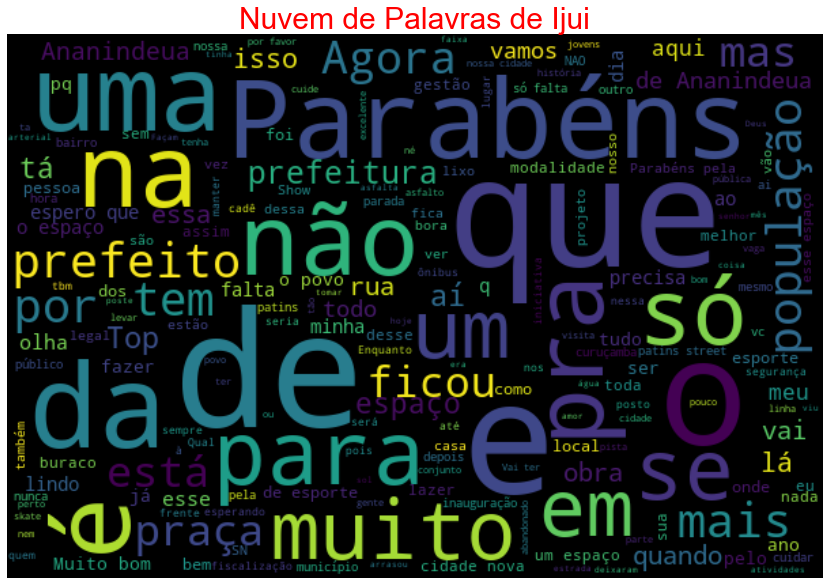

In [38]:
#Word Cloud
allWords = ' '.join( [insta for insta in df_coment['Comentarios']] )
wordCloud = WordCloud(width = 600, height = 400, random_state = 21, max_font_size = 119 ).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.title('Nuvem de Palavras de Ijui', fontsize=30, color='red')
plt.axis('off')
plt.show() 

#Mostrar todos as legendas positivas
j=1
sortedDF = df_aux.sort_values(by=['Polaridade'])
for i in range(0, sortedDF.shape[0]):
    if (sortedDF['Analise'].values[i] == 'Positivo'):
        print(str(j) + ') ' + sortedDF['Comentarios'].values[i])
        print()
        j = j + 1

#Mostrar todos as legendas negativas
j=1
sortedDF = df_aux.sort_values(by=['Polaridade'])
for i in range(0, sortedDF.shape[0]):
    if (sortedDF['Analise'].values[i] == 'Negativo'):
        print(str(j) + ') ' + sortedDF['Comentarios'].values[i])
        print()
        j = j + 1

#Plot polaridade e subjetividade
plt.figure(figsize=(8, 6))
for i in range(0, df_aux.shape[0]):
    plt.scatter(df_aux['Polaridade'].values[i], df_aux['Subjetividade'].values[i], color='blue')
    
plt.title('Análise de Sentimento Instagram')
plt.xlabel('Polaridade')
plt.ylabel('Subjetividade')
plt.show()

#Porcentagem das legendas positivas
ptlegends = df_aux[df_aux.Analise == 'Positivo']
ptlegends = ptlegends['Comentarios']

round( (ptlegends.shape[0] / df_aux.shape[0]) * 100, 1)

#Porcentagem das legendas negativas
ntlegends = df_aux[df_aux.Analise == 'Negativo']
ntlegends = ntlegends['Comentarios']

round( (ntlegends.shape[0] / df_aux.shape[0]) * 100, 1)

#mostrar as contagens de valor
df_aux['Analise'].value_counts()

#Plot e visualização das contagens
plt.title('Análise de Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
df_aux['Analise'].value_counts().plot(kind='bar')
plt.show()

# 3. Extraindo Dados do Twitter dos Clientes

In [8]:
#Carregar os dados
log = pd.read_csv ('Login_Twitter.csv')

In [9]:
#Credenciais da API do Twitter 
consumerKey = log['Chaves'][0]
consumerSecret = log['Chaves'][1]
accessToken = log['Chaves'][2]
accessTokenSecret = log['Chaves'][3]

In [10]:
#Criando o objeto de autenticação
autenticacao = tweepy.OAuthHandler(consumerKey, consumerSecret)

#Definindo o Access Token e o Access Token Secret
autenticacao.set_access_token(accessToken, accessTokenSecret)

#Criando o objeto da API
api = tweepy.API(autenticacao, wait_on_rate_limit = True)

In [11]:
# Extraindo 100 tweets de um usuário
posts = api.user_timeline(screen_name = 'BillGates', count = 100, tweet_mode="extended")

#Mostrar os últimos 5 tweets da conta
print("Mostre os 5 tweets recentes: \n")
i = 1
for tweet in posts[0:5]:
    print(str(i) + ') ' + tweet.full_text + '\n')
    i = i + 1

Mostre os 5 tweets recentes: 

1) What a night. It’s rare to have so many heroes in one place. #Goalkeepers2030 https://t.co/tvUggVtbBW

2) I had a chance to connect with @ClimateEnvoy John Kerry to kick off #ClimateWeekNYC. We’re both optimistic about recent momentum to accelerate the clean energy transition. https://t.co/NcY06cc56M

3) One of my favorite things about Bono is that he loves a good surprise. We had the chance to “photobomb” @ONEinAmerica activists, hear their @GlobalFund campaign stories, and share the latest progress in malaria research. #FightForWhatCounts https://t.co/jgGxRW5GSi

4) For the first time since 2019, the Goalkeepers community is coming together in person. I’m excited to spend time with them and hear about their innovative work to drive progress. #Goalkeepers2030 https://t.co/u8QBxRnXeX

5) RT @JMDBarroso: Amidst backsliding on the #SDGs in the past two years, this interview with @BillGates is an optimistic reminder that the mo…



In [16]:
#Criando um dataframe com uma coluna chamada Tweets
df_tweets = pd.DataFrame( [tweet.full_text for tweet in posts], columns=['Tweets'])

#Mostrar as 5 primeiras linhas de dados
df_tweets.head()

Tweets
0  What a night. It’s rare to have so many heroes...
1  I had a chance to connect with @ClimateEnvoy J...
2  One of my favorite things about Bono is that h...
3  For the first time since 2019, the Goalkeepers...
4  RT @JMDBarroso: Amidst backsliding on the #SDG...

In [17]:
df_tweets['Tweets'] = df_tweets['Tweets'].apply(cleanTxt)

# Análise de sentimento do Twitter

In [18]:
df_tweets['Subjetividade'] = df_tweets['Tweets'].apply(Subjetividade)
df_tweets['Polaridade'] = df_tweets['Tweets'].apply(Polaridade)

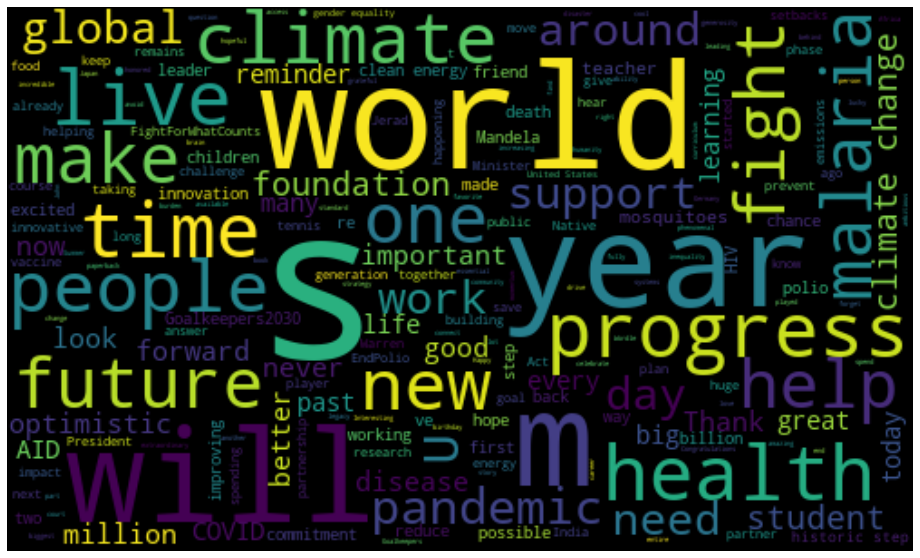

In [19]:
#Word Cloud
allWordstt = ' '.join( [twitter for twitter in df_tweets['Tweets']] )
wordCloudtt = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119 ).generate(allWordstt)

plt.imshow(wordCloudtt, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [20]:
df_tweets['Analise'] = df_tweets['Polaridade'].apply(getAnalysis)

In [25]:
#Mostrar todos os tweets positivos
j=1
sortedDFtt = df_tweets.sort_values(by=['Polaridade'])
for i in range(0, sortedDFtt.shape[0]):
    if (sortedDFtt['Analise'][i] == 'Positivo'):
        print(str(j) + ') ' + sortedDFtt['Tweets'][i])
        print()
        j = j + 1

1) Prime Minister Shinzo Abe understood that improving health is not only the right thing to do, it also makes the world safer and more prosperous. 

2) Wow, I’m blown away by your support. 

3) If you want to help teachers and students in the U.S., it’s hard to do better than giving through  — and you won’t find a better time to do it than now. I’m giving a 50% boost for every donation to DonorsChoose today.  

4) Teachers deserve our thanks – and support. I’m partnering with  and boosting all donations today by 50% to help students get back to learning!  

5) News that polio has been detected in New York wastewater samples is an urgent reminder: until we EndPolio for good, it remains a threat to us all. The global eradication strategy must be fully supported to protect people everywhere. 

6) Solving climate change is the hardest challenge humanity has ever faced but this would be a historic step forward. It represents our best chance to build an energy future in America that is clea

In [26]:
#Mostrar todos os tweet negativos
j=1
sortedDFtt = df_tweets.sort_values(by=['Polaridade'])
for i in range(0, sortedDFtt.shape[0]):
    if (sortedDFtt['Analise'][i] == 'Negativo'):
        print(str(j) + ') ' + sortedDFtt['Tweets'][i])
        print()
        j = j + 1

1) “Outbreaks are inevitable, but pandemics are optional.” –   This  video gives you a glimpse of how Big History is helping students connect the present to the past:  

2) If we had stopped the COVID pandemic in less than 100 days, we could’ve saved over 98% of the lives lost. Here’s how we can prevent it from happening again:  

3) As I look to the future, I plan to give virtually all of my wealth to the foundation. I will move down and eventually off of the list of the world’s richest people.

4) Prime Minister Abe was a friend and partner of our foundation who helped save lives around the world by championing universal health coverage and programs like the Global Fund. I’m shocked and saddened by his death.

5) Yesterday, I had a chance to spend the day focusing on climate – and the innovations that can prevent the very worst effects of climate change. 



In [27]:
#Plot polaridade e subjetividade
plt.figure(figsize=(8, 6))
for i in range(0, df_tweets.shape[0]):
    plt.scatter(df_tweets['Polaridade'][i], df_tweets['Subjetividade'][i], color='blue')
    
plt.title('Análise de Sentimento Twitter')
plt.xlabel('Polaridade')
plt.ylabel('Subjetividade')
plt.show()

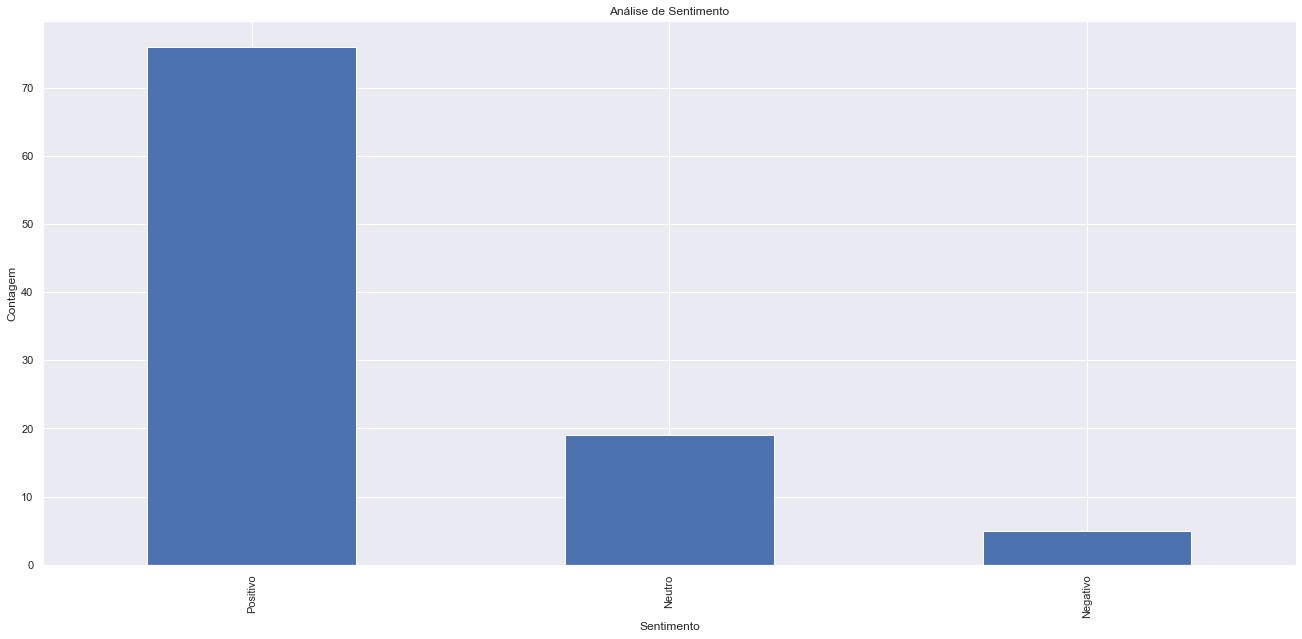

In [29]:
#Porcentagem das legendas positivas
ptlegends = df_tweets[df_tweets.Analise == 'Positivo']
ptlegends = ptlegends['Tweets']

round( (ptlegends.shape[0] / df_tweets.shape[0]) * 100, 1)

#Porcentagem das legendas negativas
ntlegends = df_tweets[df_tweets.Analise == 'Negativo']
ntlegends = ntlegends['Tweets']

round( (ntlegends.shape[0] / df_tweets.shape[0]) * 100, 1)

#mostrar as contagens de valor
df_tweets['Analise'].value_counts()

#Plot e visualização das contagens
plt.title('Análise de Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
df_tweets['Analise'].value_counts().plot(kind='bar')
plt.show()